# Rumo 
## Sprint 01
### Análise Exploratória dos dados

### BASE DE DADOS:
A base de dados fornecida foi uma planilha Excel (formato .xlsb) contendo duas abas:  

`Circulação:` > Contém informações macro relativas à malha/trajeto/seção e deslocamento do trem (trem = composição de _m_ locomotivas + _n_ vagões), ordem de serviço, horários de saída e de chegada, e tempos gastos com anomalias.  

`Ficha_trem:` > Contém informações detalhadas sobre os vagões e locomotivas quem compõem cada trem da aba anterior, por trajeto. São disponibilizadas informações como peso bruto, peso líquido, comprimento e código único de identificação do vagão/locomotiva, dentre outros.

*Para este exercício, somente a aba `Circulacao` será utilizada.*

### OBJETIVO DO PROJETO:
Estimar o horário de chegada de trens ao destino, considerando todas as possíveis variáveis de entrada do arquivo e, principalmente, tendo em mente que a a previsão de chegada do trem **precisa ser recalculada a cada avanço uma seção bloqueio considerando todos os trens que cruzarão a rota do trem sob análise**.

*Na imagem abaixo são exibidas as malhas utilizadas pela rumo, as quais são divididas em Trechos, que são subdivididos em Subtrechos, que são subdivididos em Locais, que são subdivididos em Seções de Bloqueio. 

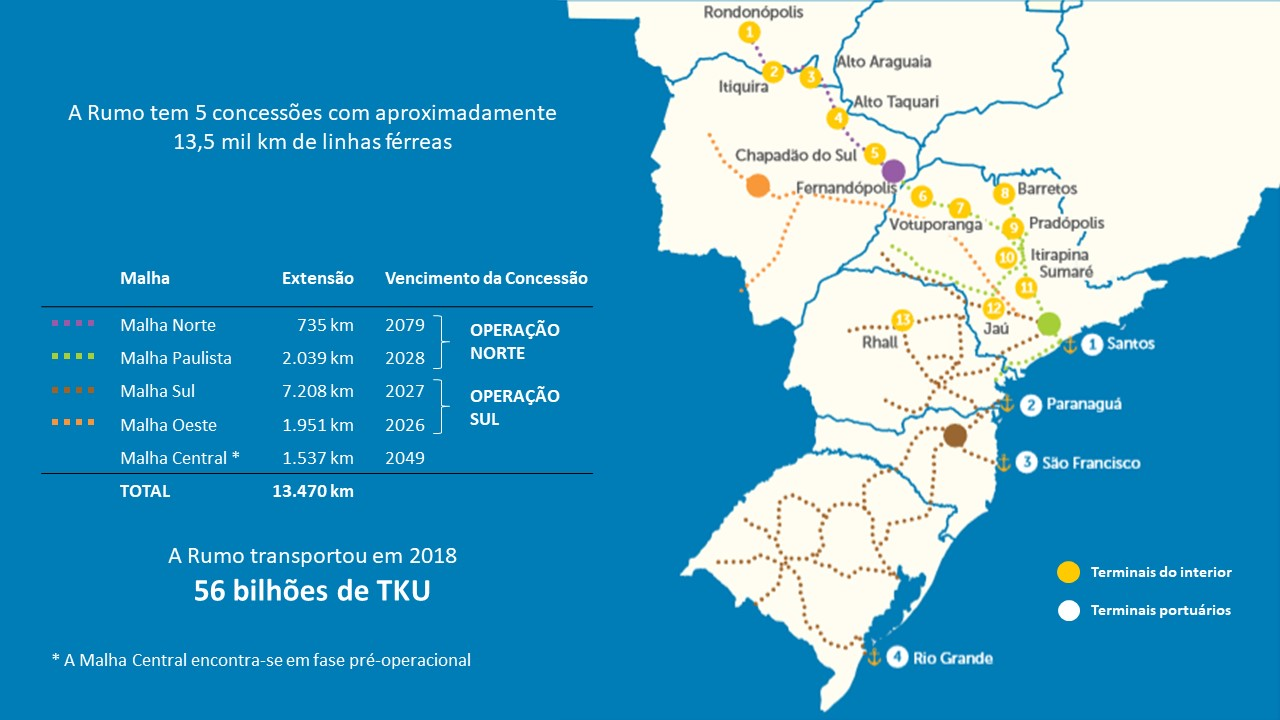

In [4]:

#display(Image("mapa_rumo.JPG"))

### Pacotes e setup

In [1]:
import pandas as pd
import sys, math
import numpy as np
import pylab as plt
import seaborn as sns
from matplotlib import colors,cm
from mpl_toolkits.mplot3d import Axes3D
import warnings
from IPython.display import Image, display

warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (30.0, 15.0)
topcolor = ['#35d457','#35d457','#31a5d4','#31a5d4','#2a66b5','#2a66b5']
botcolor = ['#ebda28','#ebda28','#de7c1b','#de7c1b','#e03b28','#e03b28']

### Importando arquivo de dados

In [2]:
path = "./circulacao.csv"
df = pd.read_csv(path, sep = ";")
display(df.head())

,Unnamed: 0,SECAO_BLOQUEIO,LOCAL,SUB_TRECHO,TRECHO,CORREDOR,PREFIXO,IDANALISE,IDTREM,IDSUBTRECHO,...,CONDUCAO,PERMANECIA,CRUZAMENTO,ANOMALIA,PROPAGACAO,ATIVO,DTVERSION,PUBLICAR,IDANALISEPARTICIONADA,PKID
0,0,ZQBZBV,ZQBZBV,T1 - ZQBZBV/ZDR,TRECHO 1 - ZBV/ZPT,NORTE - LARGA,R67,4258247.0,2745064.0,154.0,...,203.0,0.0,0.0,0.0,0.0,1.0,2019-09-10 12:19:06.000000000,0.0,NaN,253.0
1,1,ZQBZBV,ZQBZBV,T1 - ZQBZBV/ZDR,TRECHO 1 - ZBV/ZPT,NORTE - LARGA,X37,4258313.0,2745154.0,154.0,...,213.0,0.0,0.0,0.0,0.0,1.0,2019-09-10 12:19:06.000000000,0.0,NaN,319.0
2,2,ZQBZBV,ZQBZBV,T1 - ZQBZBV/ZDR,TRECHO 1 - ZBV/ZPT,NORTE - LARGA,L31,4258378.0,2745102.0,154.0,...,237.0,0.0,0.0,0.0,0.0,1.0,2019-09-10 12:19:06.000000000,0.0,NaN,384.0
3,3,ZDR1,ZDR,T0 - ZDR/PCZ,TRECHO 0 - ZPT/PSN-PCZ,NORTE - LARGA,C81,4257853.0,2745334.0,156.0,...,0.0,3789.0,0.0,0.0,0.0,1.0,2019-09-10 12:14:25.000000000,0.0,NaN,128251.0
4,4,LMRP,LMR,LMR-LID,LMR-LID,PARANAGUÁ,K01,4259283.0,2745433.0,135.0,...,0.0,1006.0,0.0,0.0,0.0,1.0,2019-09-10 12:32:12.000000000,0.0,NaN,128314.0


### Variáveis dependentes (para predição -y-):
1. `CONDUCAO`   > Tempo de condução
2. `PERMANECIA` > Tempo de permanência em uma determinada Seção Bloqueio
3. `CRUZAMENTO` > Parada devido a um cruzamento
4. `ANOMALIA`   > Autoexplicativo
4. `PROPAGACAO` > Deslocamento prejudicado por parada de outros trens à frente.

### Variável independente:

1. `SECAO_BLOQUEIO`   > A seção bloqueio pode ser compreendida como os *n* subtrechos que compõem a rota de um trem.

In [3]:
df_nova = df[['SECAO_BLOQUEIO', 'CONDUCAO', 'PERMANECIA', 'CRUZAMENTO', 'ANOMALIA', 'PROPAGACAO']]
display(df_nova.head())

,SECAO_BLOQUEIO,CONDUCAO,PERMANECIA,CRUZAMENTO,ANOMALIA,PROPAGACAO
0,ZQBZBV,203.0,0.0,0.0,0.0,0.0
1,ZQBZBV,213.0,0.0,0.0,0.0,0.0
2,ZQBZBV,237.0,0.0,0.0,0.0,0.0
3,ZDR1,0.0,3789.0,0.0,0.0,0.0
4,LMRP,0.0,1006.0,0.0,0.0,0.0


In [4]:
df_nova['TEMPO_TOTAL'] = df_nova['CONDUCAO'] + df_nova['PERMANECIA'] + df_nova['CRUZAMENTO'] + df_nova['ANOMALIA'] + df_nova['PROPAGACAO']
display(df_nova.head())

,SECAO_BLOQUEIO,CONDUCAO,PERMANECIA,CRUZAMENTO,ANOMALIA,PROPAGACAO,TEMPO_TOTAL
0,ZQBZBV,203.0,0.0,0.0,0.0,0.0,203.0
1,ZQBZBV,213.0,0.0,0.0,0.0,0.0,213.0
2,ZQBZBV,237.0,0.0,0.0,0.0,0.0,237.0
3,ZDR1,0.0,3789.0,0.0,0.0,0.0,3789.0
4,LMRP,0.0,1006.0,0.0,0.0,0.0,1006.0


In [5]:
############## Preenchimento de campos em branco ###################
df_nova = df_nova.fillna(0)

df_nova[['SB_Num']]  = df_nova[['SECAO_BLOQUEIO']]

In [6]:
############## Conversão da variável categórica para numérica   ##########################

from sklearn import preprocessing
le = preprocessing.LabelEncoder()
df_nova[['SB_Num']]  = le.fit_transform(df_nova[['SB_Num']])
df_nova[['SB_Norm']] = df_nova[['SB_Num']]

display(df_nova.head())

,SECAO_BLOQUEIO,CONDUCAO,PERMANECIA,CRUZAMENTO,ANOMALIA,PROPAGACAO,TEMPO_TOTAL,SB_Num,SB_Norm
0,ZQBZBV,203.0,0.0,0.0,0.0,0.0,203.0,1039,1039
1,ZQBZBV,213.0,0.0,0.0,0.0,0.0,213.0,1039,1039
2,ZQBZBV,237.0,0.0,0.0,0.0,0.0,237.0,1039,1039
3,ZDR1,0.0,3789.0,0.0,0.0,0.0,3789.0,909,909
4,LMRP,0.0,1006.0,0.0,0.0,0.0,1006.0,501,501


In [8]:
#################          Normalizando a variável          ##################
from sklearn.preprocessing import StandardScaler

X = df_nova[['SB_Norm']]

scaler = StandardScaler().fit(X)
X_Rs = scaler.transform(X)


df_nova[['SB_Norm']] = X_Rs
display(df_nova.head())

,SECAO_BLOQUEIO,CONDUCAO,PERMANECIA,CRUZAMENTO,ANOMALIA,PROPAGACAO,TEMPO_TOTAL,SB_Num,SB_Norm
0,ZQBZBV,203.0,0.0,0.0,0.0,0.0,203.0,1039,1.226102
1,ZQBZBV,213.0,0.0,0.0,0.0,0.0,213.0,1039,1.226102
2,ZQBZBV,237.0,0.0,0.0,0.0,0.0,237.0,1039,1.226102
3,ZDR1,0.0,3789.0,0.0,0.0,0.0,3789.0,909,0.866373
4,LMRP,0.0,1006.0,0.0,0.0,0.0,1006.0,501,-0.262622


In [9]:
#####################################     SEPARAÇÃO DA BASE     ####################################
from sklearn.model_selection import train_test_split


df_train, df_test = train_test_split(df_nova, test_size=0.30, shuffle=True)

print("Original df", df_nova.shape, "\nTrain      ", df_train.shape, "\nTest       ", df_test.shape)

Original df (266604, 9) 
Train       (186622, 9) 
Test        (79982, 9)


# Análise Inicial com algoritmos de Machine Learning

### Importar Bibliotecas de machine learning

In [10]:
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor

#requer sklearn:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score

### Regressão Linear, SGD, KNN e Tree:

In [11]:
#######################    BIBLIOTECAS    #####################
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.tree         import DecisionTreeRegressor 
from sklearn.neighbors    import KNeighborsRegressor
from sklearn.neighbors    import KNeighborsClassifier

from matplotlib           import pyplot as plt

X_train = df_train[['SB_Norm']]
Y_train = df_train[['CONDUCAO']]

print(X_train.shape)
print(Y_train.shape)

(186622, 1)
(186622, 1)


In [12]:
X_test = df_test[['SB_Norm']]
Y_test = df_test.CONDUCAO

print(X_test.shape)
print(Y_test.shape)

(79982, 1)
(79982,)


In [13]:
##################    Fórmula do R² e RSS      #####################

from sklearn.metrics import r2_score
def calc_rss(y,predicted):
    return float(((predicted - y) ** 2).sum())
    
def calc_r2(y,predicted):
    return r2_score(y, predicted)

In [14]:
a = range(1,100)
r2k = 0
l   = 0
for i in a:
    neigh  = KNeighborsRegressor(n_neighbors=i,weights='uniform').fit(X_train,Y_train)
    r2  = calc_r2(Y_test,neigh.predict(X_test))
    if r2 > r2k:
        r2k = r2
        l = i
print('Best Result: k = ', l, ', R² = %.3f'% r2k)

Best Result: k =  8 , R² = 0.461


In [15]:
################   Teste para descobrir qual o melhor K    #####################

# O teste foi realizado até k = 100. Em alguns casos em que há um grande volume de dados talvez esse número seja insuficiente.

k2         = 0
error_rate = []
low_error  = 1
        
a = range(1,100)
for i in a:
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,Y_train)
    pred_i = knn.predict(X_test)
    error = np.mean(pred_i != Y_test)
    error_rate.append(error)
    if error < low_error:
        low_error = error
        k2 = i
print('k otimizado = ', k2,'Menor erro = ', low_error)

k otimizado =  91 Menor erro =  0.9661798904753569


Text(0, 0.5, 'Error Rate')

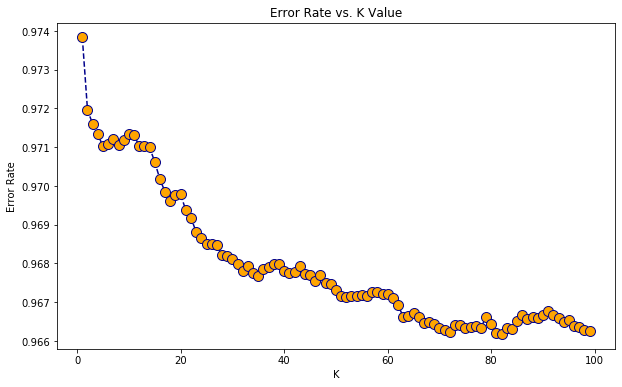

In [19]:
###################      Plot do gráfico de erros - Somente para KNN     ###################

plt.figure(figsize=(10,6))
plt.plot(a,error_rate,color='darkblue', linestyle='dashed', marker='o',
         markerfacecolor='orange', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

In [17]:
######################   FITS    ####################
linear = LinearRegression().fit(X_train,Y_train)
sgd    = SGDRegressor(max_iter=5000,alpha=0).fit(X_train,Y_train)
neigh  = KNeighborsRegressor(n_neighbors=k2,weights='uniform').fit(X_train,Y_train)
tree   = DecisionTreeRegressor().fit(X_train,Y_train)

In [18]:
############################ RESULTADOS FINAIS DE R² E RSS ####################

r2  = calc_r2(Y_test,linear.predict(X_test))
print('****** R²: ******')
print('Linear: %.4f'% r2)

r2  = calc_r2(Y_test,sgd.predict(X_test))
print('SGD:    %.4f'% r2)

r2  = calc_r2(Y_test,neigh.predict(X_test))
print('KNN:    %.4f'% r2)

r2  = calc_r2(Y_test,tree.predict(X_test))
print('TREE:   %.4f'% r2)

****** R²: ******
Linear: 0.0037
SGD:    0.0037
KNN:    0.3884
TREE:   0.4711


In [19]:
rss = calc_rss(Y_test,np.array(linear.predict(X_test).reshape(79982)))
print('***** RSS: *****')
print('Linear: %.0f'% rss)

rss = calc_rss(Y_test,np.array(sgd.predict(X_test).reshape(79982)))
print('SGD:    %.0f'% rss)

rss = calc_rss(Y_test,np.array(neigh.predict(X_test).reshape(79982)))
print('KNN:    %.0f'% rss)

rss = calc_rss(Y_test,np.array(tree.predict(X_test).reshape(79982)))
print('TREE:   %.0f'% rss)

***** RSS: *****
Linear: 116342163027
SGD:    116350815251
KNN:    71422496284
TREE:   61764308544


## CONCLUSÃO:

### A Regression Tree retornou os melhores resultados tanto do R² quanto do RSS

### Exercício do dia 30/01 sobre Regularização.

In [20]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
from sklearn.linear_model import LinearRegression, Ridge, Lasso 
from sklearn.model_selection import train_test_split, cross_val_score 
from statistics import mean 

import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import seaborn as sns; sns.set()

import math

from matplotlib import pyplot as plt
from datetime import datetime, timedelta
from scipy.interpolate import interp1d
from numpy import median

from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor  
from sklearn.metrics import r2_score

from sklearn.preprocessing import scale 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.metrics import mean_squared_error

### Método Ridge
#### Alpha=0 regressão linear comum

In [21]:
ridge2 = Ridge(alpha = 0)
ridge2.fit(X_train, Y_train) 

r2_linear = r2_score(Y_test,linear.predict(X_test))
r2_linear_treino = r2_score(Y_train,linear.predict(X_train))
print(linear.coef_)
print("Scores R^2 Treino:")
print("linear: "+str(r2_linear_treino))


print("Scores R^2 Teste:")
print("linear: "+str(r2_linear))
print(mean_squared_error(Y_test,linear.predict(X_test))) 

[[-70.69570631]]
Scores R^2 Treino:
linear: 0.003194841444190022
Scores R^2 Teste:
linear: 0.0037336784025070457
1454604.3238042016


In [22]:
ridge2 = Ridge(alpha = 0, normalize = True)
ridge2.fit(X_train, Y_train)             # Fit a ridge regression on the training data
pred = ridge2.predict(X_test)            # Use this model to predict the test data
print(ridge2.coef_)                      # Print coefficients
print(mean_squared_error(Y_test, pred))  # Calculate the test MSE

[[-70.69570631]]
1454604.3238042016


### Método Ridge
#### Utilizando diferentes valores de Alpha
#### A cada novo valor de Alpha, os valores dos parâmetros da função de regressão se aproxima de zero

In [23]:
alphas = 10**np.linspace(10,-2,100)*0.5
alphas
print(alphas.shape)
print(alphas[1])
print(alphas[99])
print(alphas)

(100,)
3782316637.773145
0.005
[5.00000000e+09 3.78231664e+09 2.86118383e+09 2.16438064e+09
 1.63727458e+09 1.23853818e+09 9.36908711e+08 7.08737081e+08
 5.36133611e+08 4.05565415e+08 3.06795364e+08 2.32079442e+08
 1.75559587e+08 1.32804389e+08 1.00461650e+08 7.59955541e+07
 5.74878498e+07 4.34874501e+07 3.28966612e+07 2.48851178e+07
 1.88246790e+07 1.42401793e+07 1.07721735e+07 8.14875417e+06
 6.16423370e+06 4.66301673e+06 3.52740116e+06 2.66834962e+06
 2.01850863e+06 1.52692775e+06 1.15506485e+06 8.73764200e+05
 6.60970574e+05 5.00000000e+05 3.78231664e+05 2.86118383e+05
 2.16438064e+05 1.63727458e+05 1.23853818e+05 9.36908711e+04
 7.08737081e+04 5.36133611e+04 4.05565415e+04 3.06795364e+04
 2.32079442e+04 1.75559587e+04 1.32804389e+04 1.00461650e+04
 7.59955541e+03 5.74878498e+03 4.34874501e+03 3.28966612e+03
 2.48851178e+03 1.88246790e+03 1.42401793e+03 1.07721735e+03
 8.14875417e+02 6.16423370e+02 4.66301673e+02 3.52740116e+02
 2.66834962e+02 2.01850863e+02 1.52692775e+02 1.155064

(100, 1, 1)
(100,)


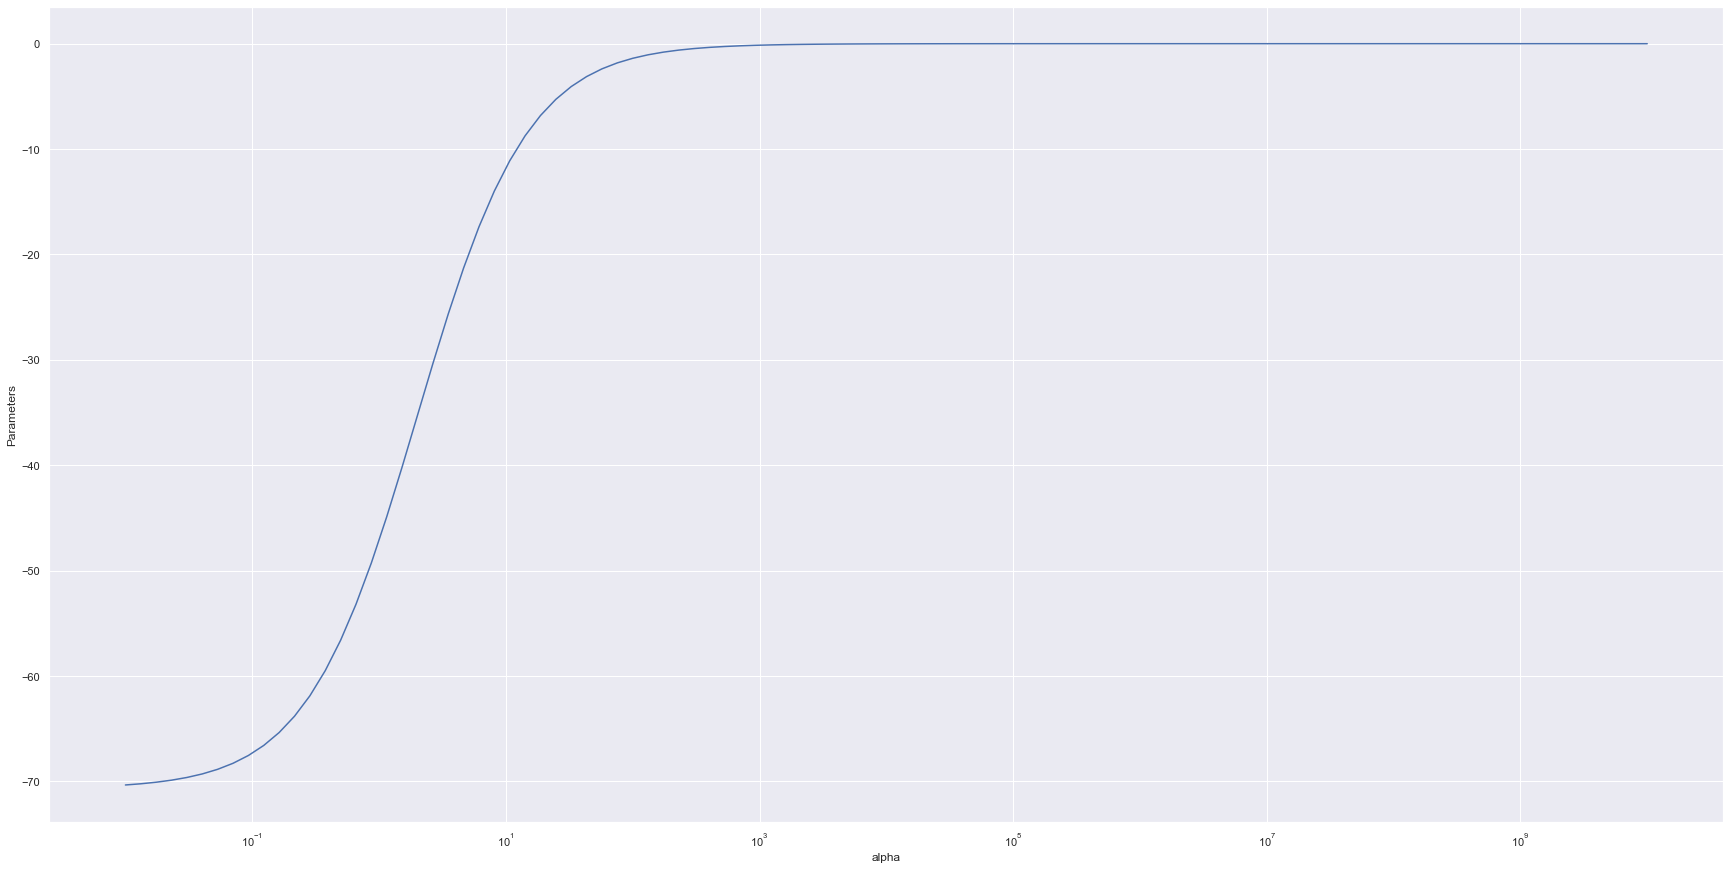

In [34]:
ridge = Ridge(normalize = True)
MSEs  = []
coefs = []

for a in alphas:
    ridge.set_params(alpha = a)
    ridge.fit(X_train, Y_train) 
    MSEs.append(mean_squared_error(Y_test,ridge.predict(X_test)))
    coefs.append(ridge.coef_)

coefs2 = np.asarray(coefs)
coefs3 = coefs2.reshape(100)
print(np.shape(coefs2))
print(np.shape(coefs3))

ax = plt.gca()
ax.plot(alphas*2, coefs3)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('Parameters')

plt.show()

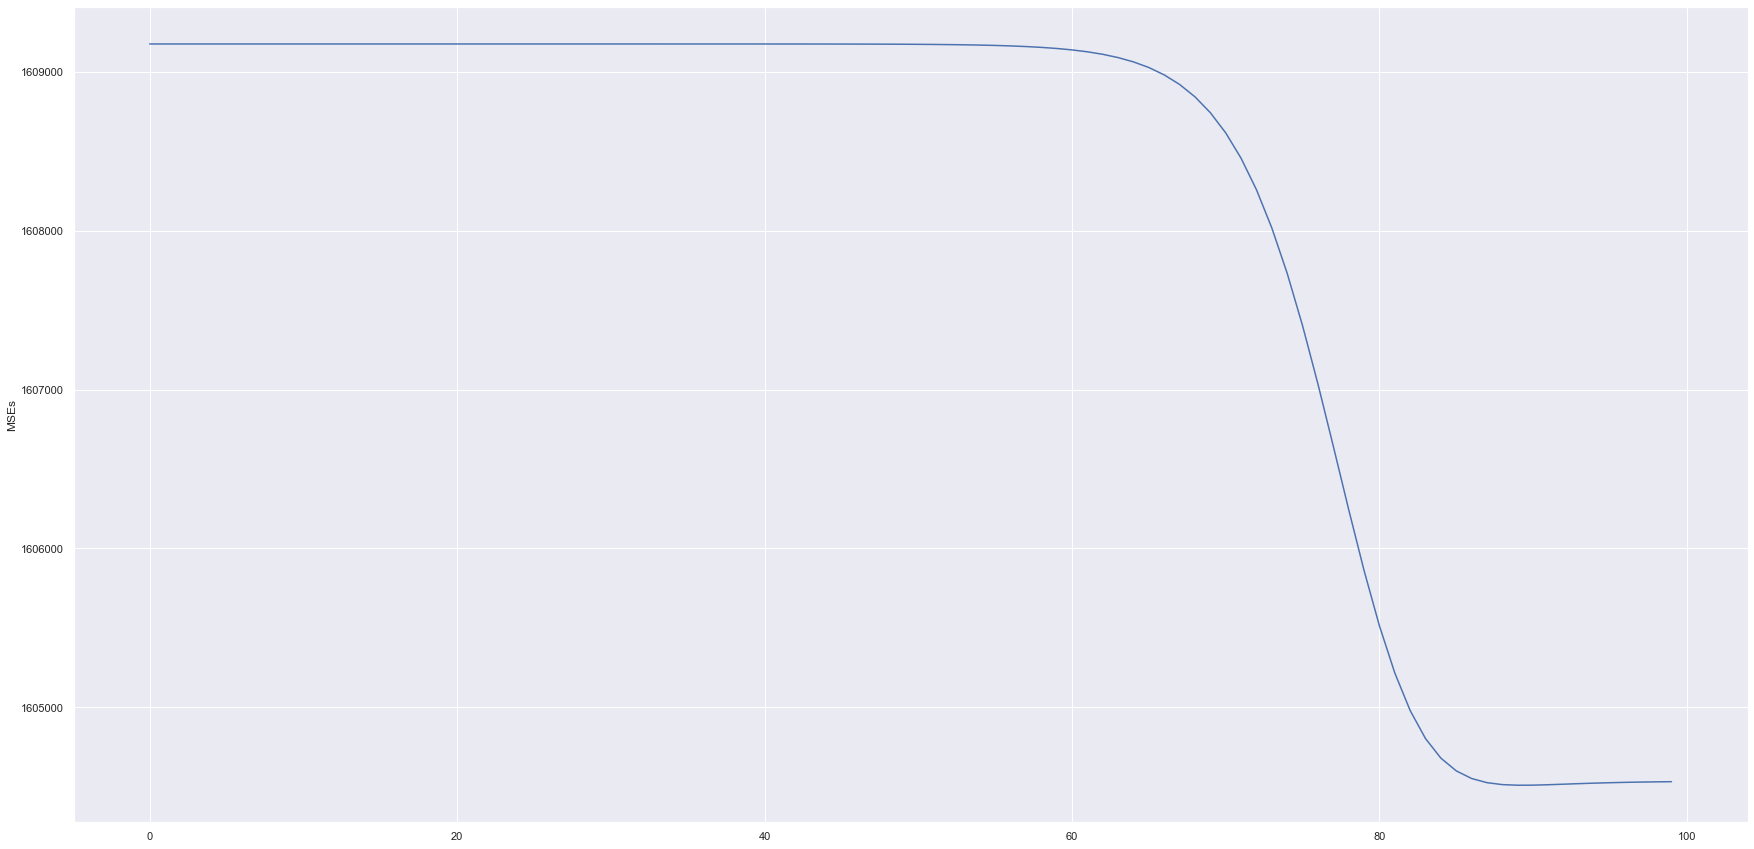

In [35]:
#plt.plot(alphas,MSEs)
plt.plot(MSEs)
plt.ylabel('MSEs')

plt.show()

### Modelo com um alpha específico que apresentou valor baixo de MSE

In [37]:
ridge = Ridge(alpha = alphas[90], normalize = True)
coefs = []

ridge.fit(X_train, Y_train) 
coefs.append(ridge.coef_)
print(mean_squared_error(Y_test,ridge.predict(X_test))) 
    
print(coefs)

1604509.4172617833
[array([[-69.00741549]])]


#### Modelo com um alpha específico que apresentou valor baixo de MSE
#### Coeficientes são diferentes dos coeficientes da regressão linear

### Método RIDGECV

In [39]:
ridge2 = Ridge(alpha = 4, normalize = True)
ridge2.fit(X_train, Y_train)             # Fit a ridge regression on the training data
pred2 = ridge2.predict(X_test)           # Use this model to predict the test data
print(ridge2.coef_) # Print coefficients
print(mean_squared_error(Y_test, pred2))          # Calculate the test MSE

[[-14.65223877]]
1607384.503484382


In [40]:
ridgecv = RidgeCV(alphas = alphas )

ridgecv = RidgeCV(alphas = alphas, scoring = 'neg_mean_absolute_error', normalize = True)

ridgecv.fit(X_train, Y_train)
ridgecv.alpha_
print(ridgecv.coef_)          # Print coefficients
print(mean_squared_error(Y_test, ridgecv.predict(X_test)))          # Calculate the test MSE

[[-72.8967103]]
1604531.259750768


#### Método Lasso
#### Max_iter - número máximo de iterações

Text(0, 0.5, 'weights')

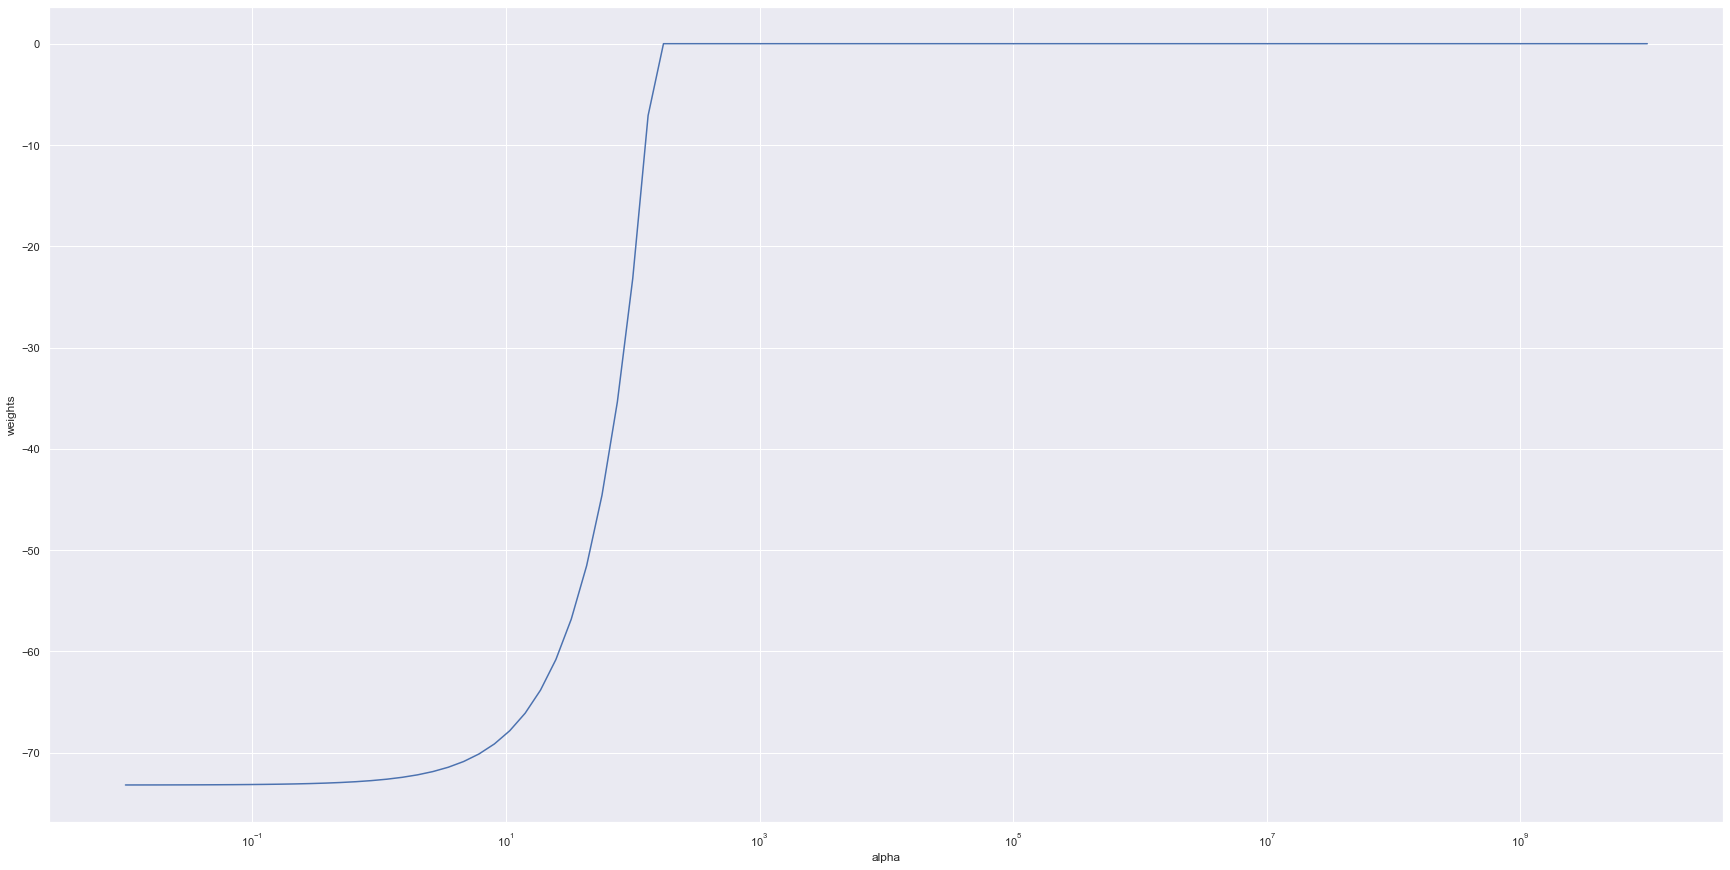

In [68]:
#lasso = Lasso(max_iter = 10000, normalize = True)
lasso = Lasso()
coefs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(scale(X_train), Y_train)
    coefs.append(lasso.coef_)
    
ax = plt.gca()
ax.plot(alphas*2, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')

In [42]:
#lassocv = LassoCV(alphas = None, cv = 10, max_iter = 100000, normalize = True)
lassocv = LassoCV(alphas = alphas)#, cv = 10, max_iter = 100000, normalize = True)
lassocv.fit(X_train, Y_train)

lasso.set_params(alpha=lassocv.alpha_)
lasso.fit(X_train, Y_train)
print(mean_squared_error(Y_test, lasso.predict(X_test)))
print(lasso.coef_)

1604534.8128710126
[-73.25618404]


### Regularização para Árvore

In [43]:
tree = DecisionTreeRegressor().fit(X_train,Y_train)
r2_tree = r2_score(Y_test,tree.predict(X_test))
r2_tree_treino = r2_score(Y_train,tree.predict(X_train))

print("Scores R^2 Treino:")
print("tree: "+str(r2_tree_treino))


print("Scores R^2 Teste:")
print("tree: "+str(r2_tree))

print(mean_squared_error(Y_test,tree.predict(X_test))) 

Scores R^2 Treino:
tree: 0.48300290440832616
Scores R^2 Teste:
tree: 0.48293946289754597
832037.1103298676


832037.1103298676
1599119.3373737356


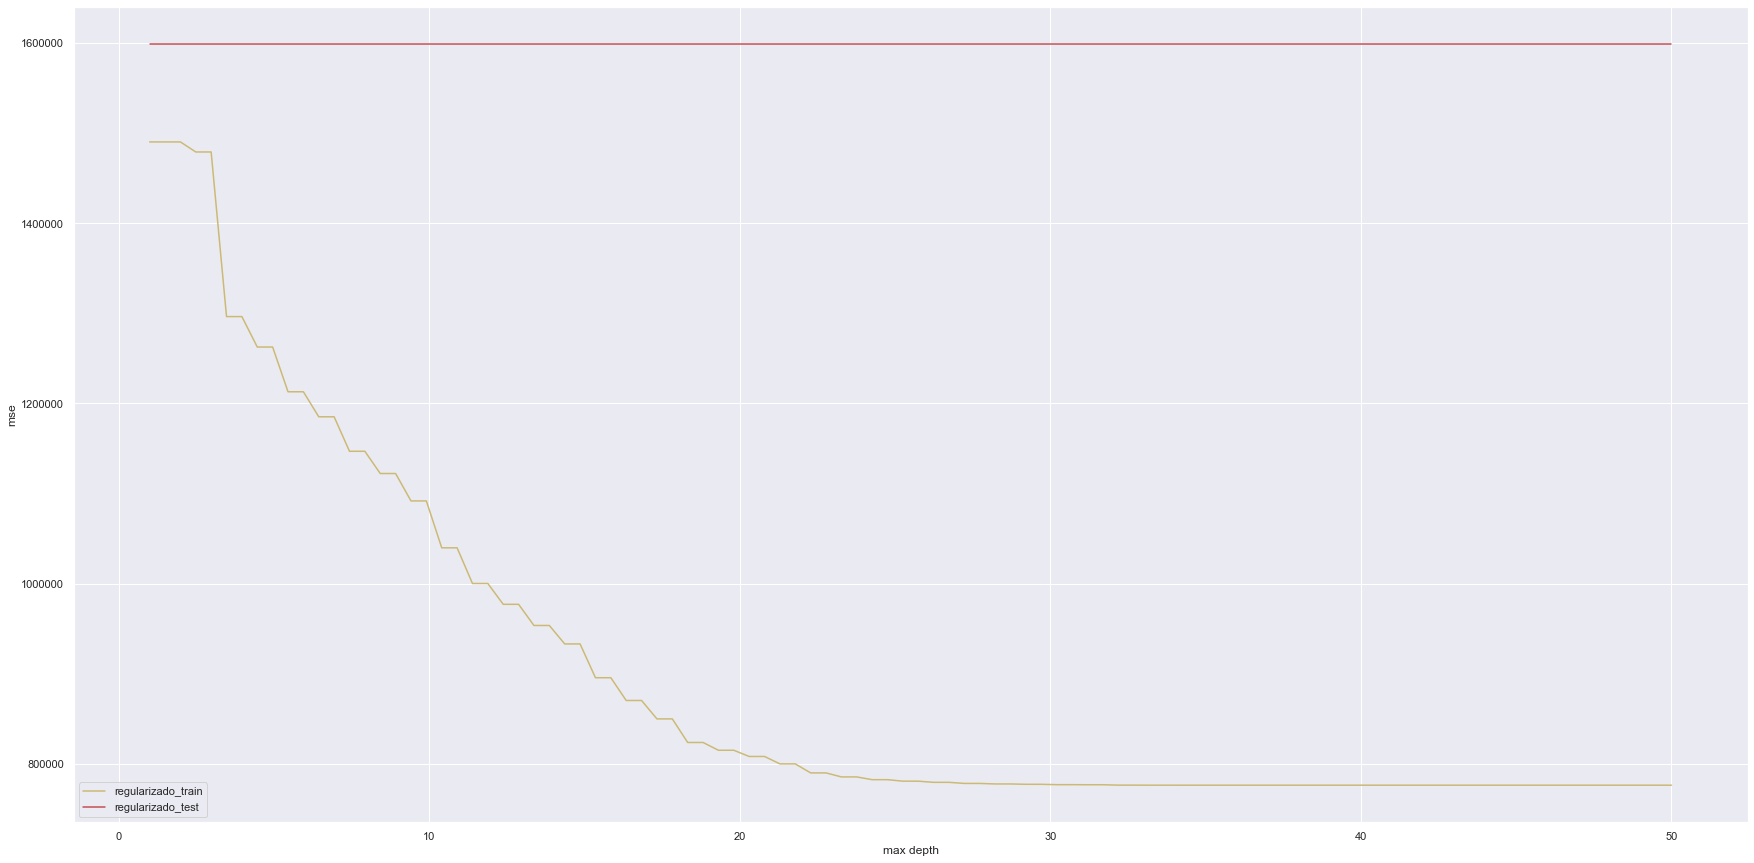

In [45]:
depth_test =  np.linspace(1., 50., num=100)

erros_train = []
erros_test = []
for depth in depth_test:
    #modelo_regularizado =  DecisionTreeRegressor(max_depth=depth).fit(X_train, y_train.values.ravel())
    modelo_regularizado =  DecisionTreeRegressor(max_depth=depth).fit(X_train, Y_train)
    Y_pred = modelo_regularizado.predict(X_test)
    erros_train.append(mean_squared_error(Y_train, modelo_regularizado.predict(X_train)))
    erros_test.append(mean_squared_error(Y_test, y_pred))
    lastMSE=mean_squared_error(Y_test, Y_pred)

print(lastMSE)
X_new = np.array(erros_test)

print(np.amin(X_new))
plt.plot(depth_test, erros_train,color='y',label='regularizado_train')
plt.plot(depth_test, erros_test,color='r',label='regularizado_test')    


plt.xlabel('max depth')
plt.ylabel('mse')
plt.legend()